In [4]:
%matplotlib inline
import numpy as np
import warnings
import matplotlib.pyplot as plt
import scipy.signal as sig
import os
from numpy.fft import rfft, irfft 
import re
import sys, os

warnings.filterwarnings("ignore")
# Add the directory containing the package to sys.path
package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/Violon/ManipViolon_Anech_08062023")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
import Tools3D as tools3d
package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/Violon/ManipViolon_Anech_08062023/array-processing/toolboxes")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
import array_processing as ap

#Vitesse du son au moment de la mesure, dependant de la temperature:
Tc = 21.5 
C = np.sqrt( 1.4 * 287 *(Tc + 273) )
Path = './'
NbMems = 256
NbViol = 6
Data = np.load('ViolinsFRFs.npz')
frq = Data['frq']
Pm = Data['Hhm']
Pr = Data['Hhr']
del Data
frqMax = 10000

# Compensating for the unknown nominal Mems FRF $H_m$
Let :
- $I$ be the FT of the hammer signal
- $M$  the FT of a Mems signal
- $H_i$ : the unknown FRF of the hammer
- $H_m$ : the unknown FRF of the mems
- $D_r$ : the Violin Directivity to the reference microphone $r$
- $D_m$ : the Violin Directivity to the MEMs microphone $m$
- $H_{ir}$ : the FRF between the hammer signal and the reference microphone signal 
$$H_{ir} = H_i D_re^{-j\frac{R_{ir}}{C}} H_r= H_i D_re^{-j\varphi_{ir}} H_r$$
- $H_{im}$ : the FRF between the hammer signal and the Mems microphone signal: 
$$H_{im} = H_i D_me^{-j\frac{R_{im}}{C}} H_m = H_i D_me^{-j\varphi_{im}} H_m$$
- $H_{rm}$ : the FRF between the reference signal and the Mems microphone signal: 
$$H_{rm} = H_r e^{-j\frac{R_{rm}}{C}} H_m = H_r H_m e^{-j\varphi_{rm}}$$

A mems spectrum is given by  :      $$ M = I H_i D_m e^{-j\varphi_{im}} H_m$$
The ref spectrum writes: :          $$ R = I H_i D_r e^{-j\varphi_{ir}} H_r$$
So that : $$\frac{M}{R}  = \frac{D_m e^{-j\varphi_{im}}}{H_r D_r e^{-j\varphi_{ir}}} H_m \Leftrightarrow H_m = \frac{M}{R} \frac{D_r e^{-j\varphi_{ir}}}{ D_m e^{-j\varphi_{im}}}H_r$$

Let also the following hypothesis : 
- We are interseted in compensating for amplitude only
- The spatial average over all the microphones $r$ does not depend on frequency : $\sum_m D_m = D$
- The FRF of the reference microphone is constant with frequency : $|H_r|=\alpha_r$, the sensitivity of the microphone

We get : 
$$|H_m| = \frac{|M|}{|R|} \frac{D_r}{ D_m }|H_r|$$

Considering spatial average over the MEMS microphones : 

$$\left<|H_m|\right> = |H_m| = \frac{\left<|M|\right>}{|R|} \beta \alpha_r$$

Text(0, 0.5, 'dB')

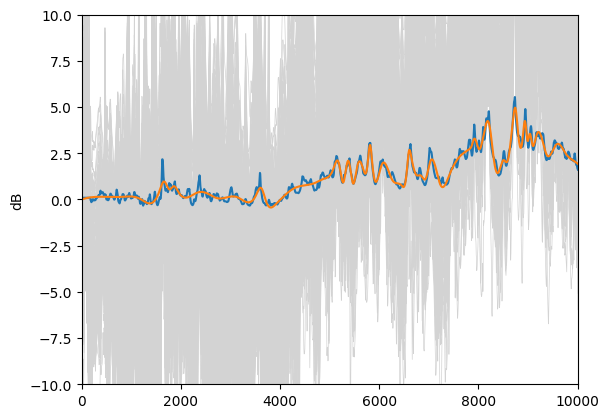

In [5]:
from scipy.interpolate import UnivariateSpline

Hm = np.mean(np.mean(np.abs(Pm), axis=2), axis=0)/np.mean(np.mean(np.abs(Pr), axis=2), axis=0)
Hm[:35] = Hm[35]

spline = UnivariateSpline(frq, Hm, s=100)
Hmf = spline(frq)
HmN = Hm/np.max(Hmf)
HmfN = Hmf/np.max(Hmf)
HmN += 1 - np.min(HmfN[:100])
HmfN += 1 - np.min(HmfN[:100])
plt.plot(frq, 20*np.log10(np.mean(np.abs(Pm)/np.abs(Pr), axis=0)), 'lightgray', lw = 0.5)
plt.plot(frq, 20*np.log10(HmN))
plt.plot(frq, 20*np.log10(HmfN))
plt.xlim([0, frqMax])
plt.ylim([-10, 10])
plt.ylabel('dB')


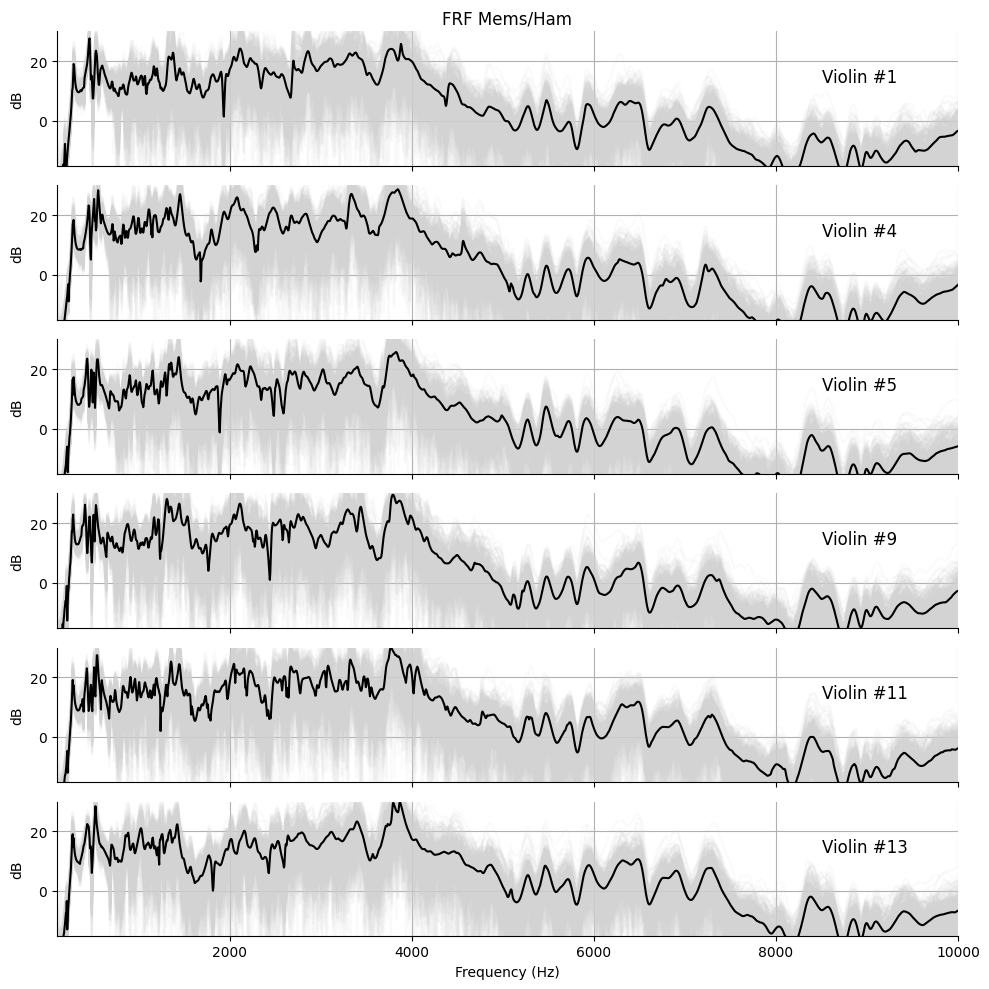

In [9]:
Pm /= Hmf[np.newaxis,:,np.newaxis]
fig,ax = plt.subplots(6,1,figsize=(10,10)) 
nf = -1 
NumViolon = [1, 4, 5, 9,11,13]  # Violons a analyser
for i in range(NbViol):
    nf += 1
    ax[nf].plot(frq, 20*np.log10(np.abs(Pm[i,:,:])),'lightgrey', alpha = 0.1)
    ax[nf].plot(frq, 20*np.log10(np.mean(np.abs(Pm[i,:,:]), axis = 1)),'k', alpha = 1)    
    ax[nf].set_ylabel('Average Magnitude (dB)')
    ax[nf].grid()    
    ax[nf].set_xlim([100, frqMax])
    ax[nf].set_ylim([-15, 30])
    ax[nf].set_ylabel('dB')
    ax[nf].spines['top'].set_visible(False)
    ax[nf].spines['right'].set_visible(False)
    ax[nf].xaxis.set_ticks_position('bottom')
    ax[nf].yaxis.set_ticks_position('left')
    ax[nf].text(8500, 13, f'Violin #{NumViolon[nf]:d}', fontsize=12, ha='left')
    #ax[nf].set_xscale('log')
    if nf < 5:
        ax[nf].set_xticklabels([])
    else:    
        ax[nf].set_xlabel('Frequency (Hz)')
    if not nf : 
        ax[nf].set_title('FRF Mems/Ham')     
fig.tight_layout()
np.savez('ViolinsPm.npz', Pm = Pm, frq = frq)

In [7]:
import time
import plotly.graph_objs as go
from IPython.display import clear_output

XYZm = np.load('XYZm_Calib3_aligne.npz')['XYZm']
XYZr = XYZm[-2:,:]
XYZm = XYZm[:-2,:]
[xmin, ymin , zmin] = np.min(XYZm, axis =0 )
[xmax, ymax , zmax] = np.max(XYZm, axis =0 )


In [8]:

FindHammerImpact = False
if FindHammerImpact:
    NbS = 5000
    # Générer des points aléatoires dans une sphère
    Rs = 0.5
    Ph = np.random.uniform(0, 2 * np.pi, NbS)
    costheta = np.random.uniform(-1, 1, NbS)
    u = np.random.uniform(0, 1, NbS)
    Th = np.arccos(costheta)
    R = Rs * np.cbrt(u)
    Xs = R * np.sin(Th)*np.cos(Ph)
    Ys = R * np.sin(Th)*np.sin(Ph)
    Zs = R * np.cos(Th) 
    XYZs = np.array([Xs,Ys,Zs]).T

    #Recherche des points d'impact du marteau
    from scipy.spatial.distance import cdist
    Bw = 100
    nB = int(len(frq)/Bw)
    R0 = 0.5
    NbS = 100
    Rss = []
    iBF = np.where((frq < 10000) & (frq > 200))[0]
    PosPtSrc = []
    for v in range(NbViol):
        Maxpos = [0,0,0]
        Src = np.zeros(NbS)
        frf = FRF[v,:,:]
        for i in range(100): # Espace Source
            Rs = R0/(i+1)
            # Générer des points aléatoires dans une sphère
            Ph = np.random.uniform(0, 2 * np.pi, NbS)
            costheta = np.random.uniform(-1, 1, NbS)
            u = np.random.uniform(0, 1, NbS)
            Th = np.arccos(costheta)
            R = Rs * np.cbrt(u)
            Xs = R * np.sin(Th)*np.cos(Ph)
            Ys = R * np.sin(Th)*np.sin(Ph)
            Zs = R * np.cos(Th) 
            XYZs = np.array([Xs,Ys,Zs]).T + Maxpos
        # Green function
            Rsm = cdist(XYZm, XYZs)
            
            Src = np.zeros(NbS)    
            for k in iBF :
                omg = 2*np.pi*frq[k]
                Gsm = np.exp(-1j*omg*Rsm/C)
                #Beamforming Light
                Pfo = frf[k,:]
                Srcf = np.dot(Gsm.T,np.conj(Pfo))
                Src += np.abs(Srcf)**2   
                
            Src /= np.max(np.abs(Src))
            previous = np.array(Maxpos)        
            Maxpos = np.array(XYZs[np.argmax(Src),:])
            Dist = np.linalg.norm(previous-Maxpos)
            
            print(f"{Maxpos[0]:.3f} {Maxpos[1]:.3f} {Maxpos[2]:.3f} {Dist:.3f}")   
        PosPtSrc.append(Maxpos)
    PosPtSrc = np.array(PosPtSrc)
    np.savez('PosPtSrc.npz', PosPtSrc = PosPtSrc)   
else :
    PosPtSrc = np.load('PosPtSrc.npz')['PosPtSrc']
    print(PosPtSrc)    
    
fig = go.Figure(data=[go.Scatter3d(name = 'Micros', x=XYZm[:,0], y=XYZm[:,1], z = XYZm[:,2], 
                                mode='markers', opacity=0.75,marker=dict(size=2,color='blue'))])
camera = dict(eye=dict(x=2*xmin, y=2*ymin, z=0))
fig.update_layout(scene_camera=camera)
fig.update_layout(scene_aspectmode='manual', 
                    scene_aspectratio=dict(x=1, y=1, z=1),
                    width=600, height = 400,
                    scene = dict(xaxis = dict(nticks=10, range=[xmin,xmax],),
                                yaxis = dict(nticks=10, range=[ymin,ymax],),
                                zaxis = dict(nticks=10, range=[zmin,zmax],),))
fig.add_trace(go.Scatter3d(name = 'Src',x=PosPtSrc[:,0], y=PosPtSrc[:,1], z = PosPtSrc[:,2], 
                            mode='markers', marker=dict(size=5,color='red', line=dict(color='black',  # Edge color
                                                                                      width=2       # Edge width
                                                                                      )), opacity=1))
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: 'PosPtSrc.npz'